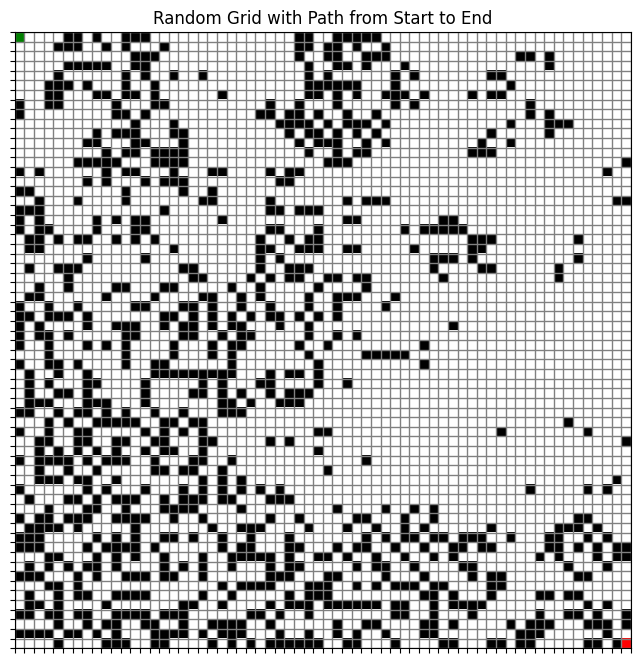

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

SEED = 12
np.random.seed(SEED)
random.seed(SEED)

def generate_random_grid_with_path(width, height, obstacle_prob=0.3):
    grid = np.random.choice([0, 1], size=(height, width), p=[1 - obstacle_prob, obstacle_prob])
    
    start = (0, 0)
    end = (height - 1, width - 1)
    
    grid[start] = 0
    grid[end] = 0
    
    def create_path_dfs(x, y, visited):
        if (x, y) == end:
            return True
        visited.add((x, y))
        
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)
        
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < height and 0 <= ny < width and (nx, ny) not in visited:
                if grid[nx, ny] == 1:
                    grid[nx, ny] = 0  
                if create_path_dfs(nx, ny, visited):
                    return True
        return False

    create_path_dfs(start[0], start[1], set())
    
    grid[start] = 2  # Mark start point
    grid[end] = 3    # Mark end point

    return grid, start, end

def display_grid(grid):
    cmap = mcolors.ListedColormap(['white', 'black', 'green', 'red'])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(grid, cmap=cmap, norm=norm)
    plt.grid(which='major', axis='both', color='gray', linestyle='-', linewidth=1)
    plt.xticks(np.arange(-0.5, grid.shape[1], 1), [])
    plt.yticks(np.arange(-0.5, grid.shape[0], 1), [])
    plt.title("Random Grid with Path from Start to End")
#     plt.axis('off')
    plt.show()

width = 64
height = 64
grid, start, end = generate_random_grid_with_path(width, height, obstacle_prob=0.4)
display_grid(grid)

In [2]:
def display_grid_with_policy(grid, policy):
    height, width = grid.shape
    
    cmap = mcolors.ListedColormap(['white', 'black', 'green', 'red'])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(grid, cmap=cmap, norm=norm)
    plt.xticks(np.arange(-0.5, width, 1), [])
    plt.yticks(np.arange(-0.5, height, 1), [])
    plt.grid(which='major', color='gray', linestyle='-', linewidth=1)
    
    arrow_directions = {
        "up": (0, -0.3),
        "down": (0, 0.3),
        "left": (-0.3, 0),
        "right": (0.3, 0)
    }
    
    for (x, y), action in policy.items():
        if grid[x, y] == 0:  
            dx, dy = arrow_directions[action]
            plt.arrow(y, x, dx,dy, head_width=0.2, head_length=0.2, fc='blue', ec='blue')
    
    plt.title("Grid with Policy Arrows")
    plt.show()
def trace_optimal_path(policy, start, end):
    path = []
    current = start
    while current != end:
        path.append(current)
        action = policy.get(current)
        if action is None:
            break
        
        if action == "right":
            current = (current[0], current[1] + 1)
        elif action == "down":
            current = (current[0] + 1, current[1])
        elif action == "left":
            current = (current[0], current[1] - 1)
        elif action == "up":
            current = (current[0] - 1, current[1])
        
    path.append(end)  
    return path

def display_grid_with_path(grid, path):
    cmap = mcolors.ListedColormap(['white', 'black', 'green', 'red', 'blue'])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    plt.figure(figsize=(8, 8))
    
    display_grid = np.copy(grid)
    
    for (i, j) in path:
        if display_grid[i, j] == 0:  
            display_grid[i, j] = 4 
    
    plt.imshow(display_grid, cmap=cmap, norm=norm)
    plt.grid(which='major', axis='both', color='gray', linestyle='-', linewidth=1)
    plt.xticks(np.arange(-0.5, grid.shape[1], 1), [])
    plt.yticks(np.arange(-0.5, grid.shape[0], 1), [])
    plt.title("Optimal Path on Random Grid")
    plt.show()

Solving MDP using Value Iteration
<!-- ![image.png](attachment:image.png) -->

Initialize $V(s)$ arbitrarily, for all $s\in\mathcal{S}$  
Initialize $\theta$ to a small positive value

$Loop:$

$\Delta\leftarrow0$

$$\begin{aligned}&v\leftarrow V(s)\\&V(s)\leftarrow\max_{a}\sum_{s^{\prime},r}p(s^{\prime},r|s,a)[r+\gamma V(s^{\prime})]\\&\Delta\leftarrow\max(\Delta,|v-V(s)|)\\&\text{l}\Delta<\theta\end{aligned}$$

Output a deterministic policy, $\pi\approx\pi*$, such that
$$\pi(s)\leftarrow\mathrm{argmax}_{a}\sum_{s',r}p(s',r|s,a)[r+\gamma V(s')]$$

In [3]:
actions = ["left","right","up","down"]
states = [(x,y) for x in range(height) for y in range(width)] 

start = (0, 0)
goal = (height - 1, width - 1)

reward  = {}
state_transition = {}
cache = [] 
def get_next_state(position, action):
    x, y = position
    moves = {
        "up": (x - 1, y) ,
        "down": (x + 1, y) ,
        "left": (x, y - 1) ,
        "right": (x, y + 1) 
    }
    next_position = moves.get(action, position)
    if 0 <= next_position[0] < height and 0 <= next_position[1] < width and grid[(next_position[0], next_position[1])] != 1:
        return next_position
    return position

for state in states:
    for action in actions:
        next_state = get_next_state(state, action)
        if next_state == state: 
            state_transition[(state, action, state)] = 1
        else:
            state_transition[(state, action, next_state)] = 1
            
for state in states:
    for action in actions:
        next_state = get_next_state(state,action)
        if state == goal:
            reward[(state,action,next_state)] = 1
        elif next_state == state:  
            reward[(state,action,next_state)] = -0.5
        else:
            reward[(state,action,next_state)] = -0.1

def value_iteration(states,actions,state_transition,reward,goal,discount=0.9):
    value_function = {state:0 for state in states}
    policy = {state:'down' for state in states}
    
    theta = 1e-3
    iteration = 0 
    while True:
        delta = 0
        
        for state in states:
            best_action_value = float('-inf')
            action_values = []
                        
            for action in actions:
                action_values.append(sum([state_transition.get((state,action,next_state),0)*\
                                            (reward.get((state,action,next_state),0)+discount*value_function[next_state])\
                                            for next_state in states]))
            value = value_function[state]
            max_action_val = max(action_values) 
            if max_action_val>best_action_value:
                best_action_value = max_action_val
                best_action = actions[action_values.index(best_action_value)]
                
            delta = max(delta,abs(value-max_action_val))
            
            value_function[state] = max_action_val
            policy[state] = best_action

        if delta<theta:
            break
        iteration += 1
        
    return value_function,policy

In [4]:
value_func ,policy = value_iteration(states,actions,state_transition,reward,goal,discount=0.9)

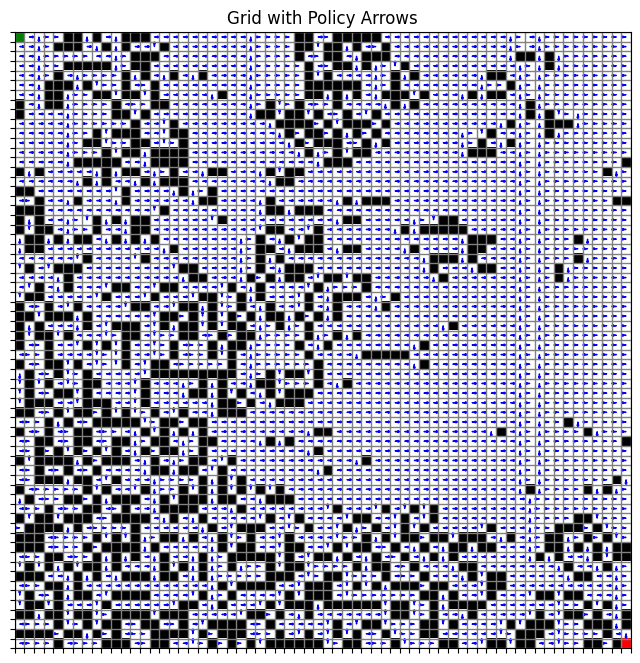

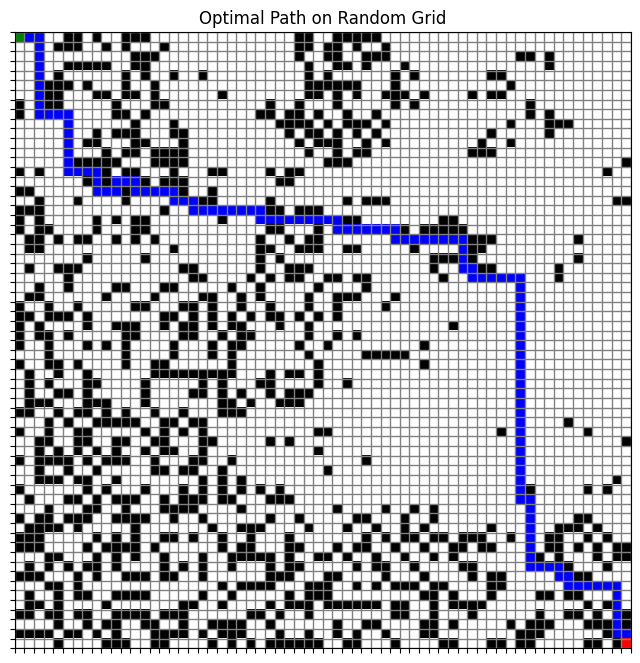

In [5]:
display_grid_with_policy(grid, policy)
path = trace_optimal_path(policy, (0,0), (height-1,width-1))
display_grid_with_path(grid,path)